In [1]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=bfec678707ba531410fe9f1aa22b382339b50b99e22fd877b8b09165e3064f09
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [19]:
import pandas as pd
import numpy as np
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
#from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, Dense, Dropout
from keras.optimizers import Adamax
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

# Load dataset

In [3]:
song = pd.read_csv("Songs.csv")
song

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new sh*t\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...
...,...,...,...
1094,Fool's Garden,The Tocsin,You saw her standing at the gateway\nwith her ...
1095,Fool's Garden,Finally,No longer the same train\nIt's reelin' on a di...
1096,Fool's Garden,One Fine Day,Who's gonna cover me\nwhen I shiver in a frigo...
1097,Fool's Garden,The Principal Thing,Do you have a problem?\nDo you wanna whine?\nD...


In [4]:
rows = 15

# Reduce the number of rows for each category
df = song.groupby('Artist').apply(lambda x: x.sample(n=rows)).reset_index(drop=True)

# Data Preprocessing

In [5]:
song_singer = df["Artist"] + "\nlyrics start\n" + df["Lyrics"]
song_singer = song_singer.str.lower().str.replace(r"[^A-Za-z0-9'\s]", "", regex=True)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(song_singer)
tot_words = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(song_singer)

In [7]:
seq_len = 100
inputs = []
targets = []

for seq in sequences:
  for i in range(1, len(seq)):
    n_gram = seq[:i+1]
    if len(n_gram) > seq_len:
      n_gram = n_gram[-seq_len:]

    inputs.append(n_gram[:-1])
    targets.append(n_gram[-1])

In [8]:
inputs = pad_sequences(inputs, maxlen=seq_len, padding='pre')
#targets = np.eye(tot_words)[targets]
targets = keras.utils.to_categorical(targets, num_classes=tot_words)

In [9]:
print(inputs.shape, targets.shape, tot_words)

(178192, 100) (178192, 10341) 10341


In [13]:
def rnn_model(seq_length, num_words):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(num_words, output_dim=256, input_length = seq_length))

    # GRU layer
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(GRU(128))
    model.add(Dropout(0.1))

    # Dense layer
    model.add(Dense(num_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
model_singer = rnn_model(seq_len, tot_words)

model_singer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          2647296   
                                                                 
 gru (GRU)                   (None, 100, 128)          148224    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10341)             1333989   
                                                                 
Total params: 4228581 (16.13 MB)
Trainable params: 422

In [16]:
history = model_singer.fit(inputs, targets, epochs=70, batch_size=128)

Epoch 1/70
1393/1393 [==============================] - 71s 45ms/step - loss: 6.5121 - accuracy: 0.0467
Epoch 2/70
1393/1393 [==============================] - 33s 24ms/step - loss: 5.6673 - accuracy: 0.1037
Epoch 3/70
1393/1393 [==============================] - 31s 22ms/step - loss: 5.1246 - accuracy: 0.1499
Epoch 4/70
1393/1393 [==============================] - 29s 21ms/step - loss: 4.6917 - accuracy: 0.1890
Epoch 5/70
1393/1393 [==============================] - 29s 21ms/step - loss: 4.3450 - accuracy: 0.2235
Epoch 6/70
1393/1393 [==============================] - 29s 21ms/step - loss: 4.0579 - accuracy: 0.2528
Epoch 7/70
1393/1393 [==============================] - 29s 21ms/step - loss: 3.8159 - accuracy: 0.2813
Epoch 8/70
1393/1393 [==============================] - 28s 20ms/step - loss: 3.6051 - accuracy: 0.3075
Epoch 9/70
1393/1393 [==============================] - 28s 20ms/step - loss: 3.4258 - accuracy: 0.3322
Epoch 10/70
1393/1393 [==============================] - 28s 20m

In [17]:
accu = history.history["accuracy"]
los = history.history["loss"]

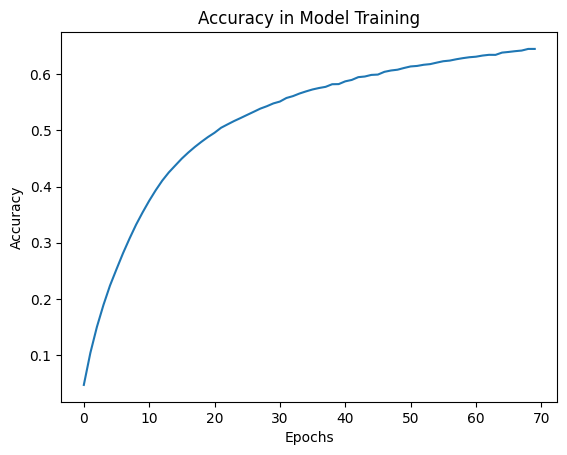

In [23]:
#plt.plot(los,label='loss')
plt.plot(accu, label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.legend()
plt.title("Accuracy in Model Training")
plt.savefig("accuracy")
plt.show()

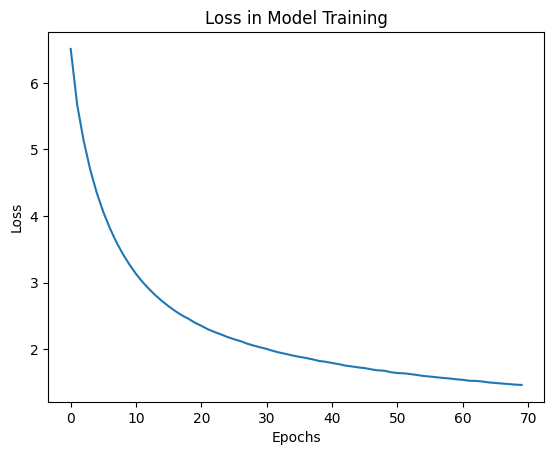

In [24]:
plt.plot(los,label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.title("Loss in Model Training")
plt.savefig("loss")
plt.show()

In [ ]:
def generate_text(model, token, seed_text, max_sequence_len, next_words):

    for _ in range(next_words):
        token_list = token.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]

        predicted = np.argmax(predicted_probs) + 1

        output_word = ""
        for word,index in token.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
        return seed_text.title()

In [ ]:
# The seed title for the lyrics generation
seed_title = "taylor swift"

# The number of words you want to generate
num_words = 400

# Call the function to generate lyrics
# Make sure the model and tokenizer names match what you've defined in your environment
generated_lyrics = generate_text(model_singer, tokenizer, seed_title, seq_len, num_words)

# Print the generated lyrics
print(generated_lyrics)

Taylor Swift Want I Is I Smile I Smile You Hey You Waste It You At There Up You One A Won'T All On I Back To And I Smile Me You At I Be Wrong You Fly You A Call A Call A High Top What Not At And You New To My Ngga Why And Can And And You At On Me Heart Ain'T Now Your Rain Out For And You Not 'Cause Can You Say That On It City And Did And Turn And Walk Of I Back A Call Proud To Air Loud You Is Town To Can'T All I Man Keep In Both For On On I Had A Once I'M Public To Head Try A High Pretty Tonight A Bitter Together Was Me What And And And That And I Said On On On On I Had A Once A Choke A Its Way What And You Relax It We Can'T Can'T Can'T See It I'M Yeah By It We Can'T Can'T Say That Down You Is Oh And You Be I One A Work You Said Come Of In Me To And Make Now Only And You Been Couldn'T All Ain'T Ain'T Me What In On And You Have Me In Me Love We Have Me A Making Me Trying A Feet A Let And Might All Chill Bed When I Say That You Will Will All See I Be I Who If And You We If You If You If 

In [ ]:
model_singer.save('lyrics_artist.h5')

# pretrained Models

In [ ]:
import torch
from transformers import AutoTokenizer, CTRLLMHeadModel

tokenizer = AutoTokenizer.from_pretrained("Salesforce/ctrl")
model = CTRLLMHeadModel.from_pretrained("Salesforce/ctrl")

# CTRL was trained with control codes as the first token
inputs = tokenizer("Horror Tylor Swift", return_tensors="pt")
#inputs["input_ids"][0, 0].item()
#tokenizer.control_codes.values()
#assert inputs["input_ids"][0, 0].item() in tokenizer.control_codes.values()

sequence_ids = model.generate(inputs["input_ids"],max_length =400)
sequences = tokenizer.batch_decode(sequence_ids)
print(sequences)

['Horror Tylor Swift and I were in the back of the car when we heard a loud bang. We looked out the window and saw a huge hole in the side of the car. We looked at each other and said that we were going to go back to the car and see what was going on. We got out of the car and walked back to the car. We looked at the hole in the side of the car and saw that it was a huge hole in the side of the car. We looked at each other and said that we were going to go back to the car and see what was going on. We got back in the car and drove back to the car. We looked at each other and said that we were going to go back to the car and see what was going on. We got back in the car and drove back to the car. We looked at each other and said that we were going to go back to the car and see what was going on. We got back in the car and drove back to the car. We looked at each other and said that we were going to go back to the car and see what was going on. We got back in the car and drove back to th